In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
#!unzip un.zip

In [2]:
from keras.layers import Conv2D, Flatten, Lambda, Conv2DTranspose, Reshape, Input, Dense, ReLU, BatchNormalization
from keras.models import Model
import tensorflow as tf
import keras.backend as K
import pickle
import cv2
import numpy as np
import os
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
!cp '/gdrive/My Drive/malaria-dataset/un.pkl' 'un.pkl'

In [4]:
with open('un.pkl', 'rb') as file_in:
  imgs = pickle.load(file_in)

In [5]:
!cp '/gdrive/My Drive/malaria-dataset/in_100.pkl' 'in_100.pkl'

In [6]:
with open('in_100.pkl', 'rb') as file_in:
  p_imgs = pickle.load(file_in)
p_imgs = p_imgs[:96]

In [7]:
latent_shape = (64,)
batch_size=32

In [8]:
def train_val_test(imgs):
  n = len(imgs)
  sp1 = int(n * 0.7)
  sp2 = int(n * 0.8)
  train, val, test = imgs[:sp1], imgs[sp1:sp2], imgs[sp2:]
  print('train: %d\nval: %d\ntest: %d' % (len(train), len(val), len(test)))
  return train, val, test

In [9]:
imgs_train, imgs_val, imgs_test = train_val_test(imgs)

train: 9645
val: 1378
test: 2756


In [10]:
train_mult = int(len(imgs_train)/batch_size) * batch_size
val_mult = int(len(imgs_val)/batch_size) * batch_size
test_mult = int(len(imgs_test)/batch_size) * batch_size

In [11]:
def make_encoder(input_shape, bn=False, kernel_size=(5,5)):
  def block(num_filters, layer_in):
    out = Conv2D(num_filters, kernel_size, strides=(2,2), padding='same')(layer_in)
    if bn:
      out = BatchNormalization()(out)
    out = ReLU()(out)

    return out

  enc_input = Input(shape=input_shape)

  encoder = block(16, enc_input)

  encoder = block(32, encoder)

  encoder = block(32, encoder)

  encoder = block(64, encoder)

  encoder = Flatten()(encoder)

  #mean = Conv2D(64, kernel_size, strides=(2,2), padding='same', activation='linear', name='enc_mean')(encoder)
  #log_var = Conv2D(64, kernel_size, strides=(2,2), padding='same', activation='linear', name='enc_var')(encoder)

  mean = Dense(64, activation='linear', name='enc_mean')(encoder)
  log_var = Dense(64, activation='linear', name='enc_var')(encoder)

  enc_model = Model(inputs=[enc_input], outputs=[mean, log_var])

  return enc_model

def make_decoder(bn=False, kernel_size=(5,5)):
  def block(num_filters, layer_in):
    out = Conv2DTranspose(num_filters, kernel_size, strides=(2,2), padding='same')(layer_in)
    if bn:
      out = BatchNormalization()(out)
    out = ReLU()(out)

    return out

  dec_input = Input(shape=latent_shape)

  decoder = Dense(576, activation='relu')(dec_input)

  decoder = Reshape((3,3,64))(decoder)

  decoder = block(64, decoder)

  decoder = block(32, decoder)

  decoder = block(32, decoder)

  decoder = block(16, decoder)

  recon_out = Conv2DTranspose(3, kernel_size, strides=(2,2), padding='same', activation='sigmoid')(decoder)

  dec_model = Model(inputs=dec_input, outputs=recon_out)

  return dec_model

In [ ]:
img_input = Input(batch_shape=(batch_size, 96, 96, 3))

enc = make_encoder((96, 96, 3))
t_mean, t_log_var = enc(img_input)

def sampling(args):
  t_mean, t_log_var = args
  return K.random_normal(t_mean.shape) * K.exp(0.5 * t_log_var) + t_mean

t = Lambda(sampling, name='sampling')([t_mean, t_log_var])

dec = make_decoder()
decoder_mean = dec(t)

vae = Model(inputs=img_input, outputs=decoder_mean)

In [12]:
def vlb(img_input, decoder_mean, t_mean, t_log_var, kl_weight=1.0):
    kl = 0.5 * K.sum(K.exp(t_log_var) + tf.square(t_mean) - 1.0 - t_log_var, axis=-1)
    mse = K.square(img_input - decoder_mean)
    mse = K.sum(mse, axis=[1, 2, 3])
    return K.mean(kl_weight * kl + mse)

In [ ]:
loss = vlb(img_input, decoder_mean, t_mean, t_log_var)

In [ ]:
vae.compile(optimizer=Adam(lr=1e-3), loss=lambda x, y: loss)

In [13]:
def vlb_num(img, img_ae, mu, logvar, kl_weight=1):
    kl = 0.5 * np.sum((np.exp(logvar) + np.square(mu) - 1.0 - logvar), axis=-1)
    mse = np.square(img - img_ae)
    mse = np.sum(mse, axis=(0, 1, 2))
    return kl, mse, kl_weight * kl + mse

In [ ]:
from matplotlib import pyplot as plt
import keras

class Display(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:
          batch_size = 96
          np_ae = np.clip(vae.predict(imgs_val[:batch_size]), 0.0, 1.0)
          np_mu, np_logvar = enc.predict(imgs_val[:batch_size])

          p_ae = np.clip(vae.predict(p_imgs[:batch_size]), 0.0, 1.0)
          p_mu, p_logvar = enc.predict(p_imgs[:batch_size])

          print("normal")
          self.disp_imgs(imgs_val)
          self.disp_imgs(np_ae)
          
          self.disp_imgs(self.get_resid(np_ae[:batch_size], imgs_val[:batch_size]))

          print(vlb_num(imgs_val[0], np_ae[0], np_mu[0], np_logvar[0]))
          
          np_avg = np.mean(np.array([list(vlb_num(imgs_val[i], np_ae[i], np_mu[i], np_logvar[i])) for i in range(batch_size)]), axis=0)
          print(np_avg)

          print('\n')

          print("parasitic")
          self.disp_imgs(p_imgs)
          self.disp_imgs(p_ae)

          self.disp_imgs(self.get_resid(p_imgs[:batch_size], p_ae))
          
          print(vlb_num(p_imgs[0], p_ae[0], p_mu[0], p_logvar[0]))

          p_avg = np.mean(np.array([list(vlb_num(p_imgs[i], p_ae[i], p_mu[i], p_logvar[i])) for i in range(batch_size)]), axis=0)
          print(p_avg)

          print('\n')

    def get_resid(self, im1, im2):
        np_resid = []
        for img in np.clip(np.abs(im1 - im2), 0.0, 1.0):
          img = img*255.0
          img = img.astype(np.uint16)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          np_resid.append(img)
        np_resid = np.array(np_resid)
        return np_resid
    
    def disp_imgs(self, im_arr, n_samples=5):
        plt.figure()
        for i in range(n_samples):
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(im_arr[i, :])
            ax.axis('off')
        plt.show()

In [ ]:
from keras.callbacks import ModelCheckpoint

base_dir = '/gdrive/My Drive/malaria-dataset/models'

checkpoint_dir = 'mseACTUAL'

checkpoint_path = os.path.join(base_dir, checkpoint_dir)

os.mkdir(checkpoint_path)

checkpoint = ModelCheckpoint(os.path.join(checkpoint_path, '{epoch:02d}-{val_loss:.2f}.h5'), save_best_only=False)

Train on 9632 samples, validate on 1376 samples
Epoch 1/200
9632/9632 [==============================] - 6s 662us/step - loss: 811.9332 - val_loss: 426.7794
normal


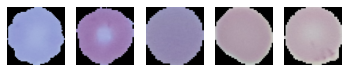

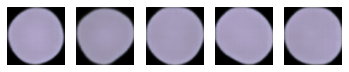

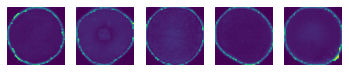

(5.162439346313477, 411.2586539358217, 416.4210932821352)
[ 10.92290175 398.35324726 409.27614902]


parasitic


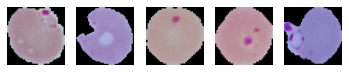

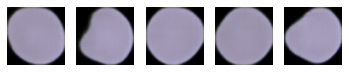

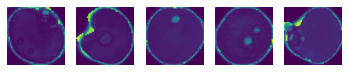

(5.9755401611328125, 379.61076901189864, 385.58630917303145)
[ 11.75134975 523.45694706 535.20829681]


Epoch 2/200
9632/9632 [==============================] - 6s 586us/step - loss: 380.4779 - val_loss: 349.8667
Epoch 3/200
9632/9632 [==============================] - 6s 593us/step - loss: 333.5083 - val_loss: 317.9385
Epoch 4/200
9632/9632 [==============================] - 6s 630us/step - loss: 308.6331 - val_loss: 297.5115
Epoch 5/200
9632/9632 [==============================] - 6s 599us/step - loss: 269.9762 - val_loss: 250.9628
Epoch 6/200
9632/9632 [==============================] - 6s 603us/step - loss: 234.8186 - val_loss: 233.5789
normal


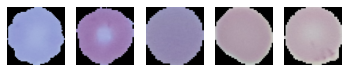

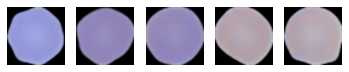

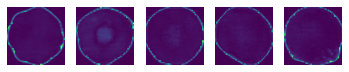

(3.1858444213867188, 224.30378616266694, 227.48963058405366)
[  5.55756633 215.68514573 221.24271206]


parasitic


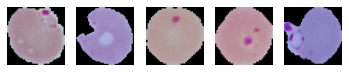

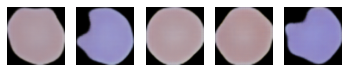

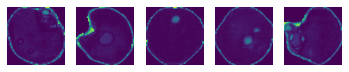

(2.463634490966797, 221.96208455689415, 224.42571904786095)
[  6.3251177  286.80328138 293.12839908]


Epoch 7/200
9632/9632 [==============================] - 6s 606us/step - loss: 221.5404 - val_loss: 220.2480
Epoch 8/200
9632/9632 [==============================] - 6s 587us/step - loss: 215.0452 - val_loss: 213.2240
Epoch 9/200
9632/9632 [==============================] - 6s 589us/step - loss: 205.7750 - val_loss: 205.6211
Epoch 10/200
9632/9632 [==============================] - 6s 605us/step - loss: 201.3469 - val_loss: 203.2166
Epoch 11/200
9632/9632 [==============================] - 6s 596us/step - loss: 196.5494 - val_loss: 198.7148
normal


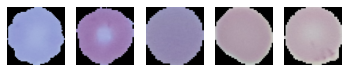

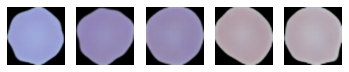

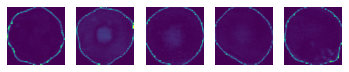

(2.2240257263183594, 213.3206350926542, 215.54466081897255)
[  4.63972044 184.63174481 189.27146525]


parasitic


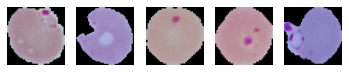

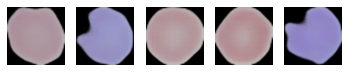

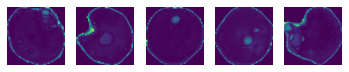

(2.1922061443328857, 205.10149830722094, 207.29370445155382)
[  5.46319992 247.78284486 253.24604478]


Epoch 12/200
9632/9632 [==============================] - 6s 581us/step - loss: 193.4112 - val_loss: 192.7204
Epoch 13/200
9632/9632 [==============================] - 6s 576us/step - loss: 189.5927 - val_loss: 192.7872
Epoch 14/200
9632/9632 [==============================] - 5s 567us/step - loss: 185.2592 - val_loss: 194.3211
Epoch 15/200
9632/9632 [==============================] - 5s 560us/step - loss: 182.4981 - val_loss: 185.8326
Epoch 16/200
9632/9632 [==============================] - 6s 582us/step - loss: 181.6014 - val_loss: 184.8222
normal


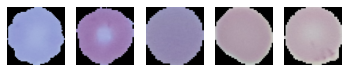

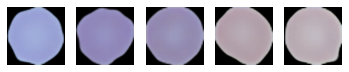

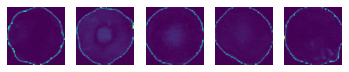

(2.055508613586426, 203.14760943077422, 205.20311804436065)
[  4.13075401 170.51846801 174.64922202]


parasitic


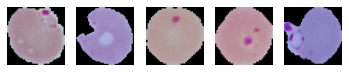

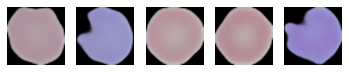

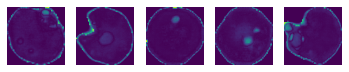

(1.9840189218521118, 186.58792701067097, 188.57194593252308)
[  4.96590178 231.0425257  236.00842748]


Epoch 17/200
9632/9632 [==============================] - 6s 581us/step - loss: 178.6792 - val_loss: 183.7368
Epoch 18/200
9632/9632 [==============================] - 6s 572us/step - loss: 175.8188 - val_loss: 179.1203
Epoch 19/200
9632/9632 [==============================] - 6s 578us/step - loss: 173.1895 - val_loss: 181.0211
Epoch 20/200
9632/9632 [==============================] - 6s 578us/step - loss: 172.6065 - val_loss: 177.9351
Epoch 21/200
9632/9632 [==============================] - 5s 568us/step - loss: 170.0747 - val_loss: 173.3001
normal


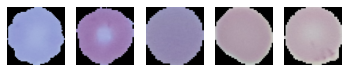

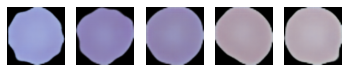

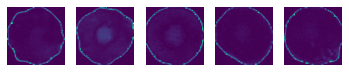

(2.1695728302001953, 141.62184753572703, 143.79142036592722)
[  3.59428829 159.58697317 163.18126146]


parasitic


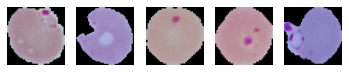

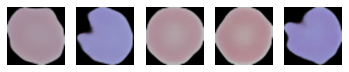

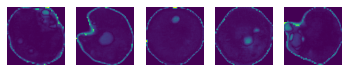

(1.8107094764709473, 177.61019602763213, 179.42090550410308)
[  4.34272794 220.33016241 224.67289035]


Epoch 22/200
9632/9632 [==============================] - 6s 572us/step - loss: 167.1286 - val_loss: 173.5458
Epoch 23/200
9632/9632 [==============================] - 5s 561us/step - loss: 165.0691 - val_loss: 174.4909
Epoch 24/200
9632/9632 [==============================] - 6s 575us/step - loss: 163.6043 - val_loss: 172.2761
Epoch 25/200
9632/9632 [==============================] - 5s 569us/step - loss: 161.0325 - val_loss: 167.7969
Epoch 26/200
9632/9632 [==============================] - 6s 576us/step - loss: 158.5817 - val_loss: 168.3815
normal


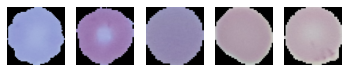

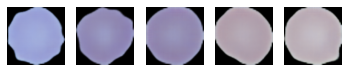

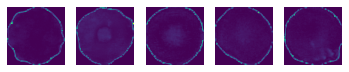

(2.2842068672180176, 131.5254412597048, 133.8096481269228)
[  3.43958018 155.24303057 158.68261076]


parasitic


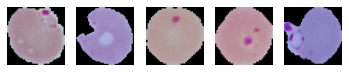

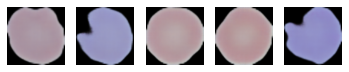

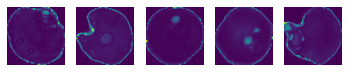

(1.9794591665267944, 157.13035210775368, 159.10981127428047)
[  4.14483538 213.04486149 217.18969687]


Epoch 27/200
9632/9632 [==============================] - 6s 600us/step - loss: 157.9150 - val_loss: 168.1260
Epoch 28/200
9632/9632 [==============================] - 6s 576us/step - loss: 155.6753 - val_loss: 161.8338
Epoch 29/200
9632/9632 [==============================] - 6s 585us/step - loss: 154.6075 - val_loss: 167.4191
Epoch 30/200
9632/9632 [==============================] - 5s 560us/step - loss: 153.2525 - val_loss: 160.6225
Epoch 31/200
9632/9632 [==============================] - 6s 582us/step - loss: 151.5334 - val_loss: 163.7329
normal


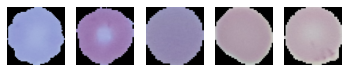

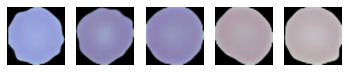

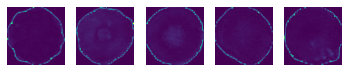

(2.0796775817871094, 127.14820065628749, 129.2278782380746)
[  3.25008967 150.06443411 153.31452378]


parasitic


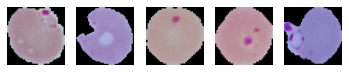

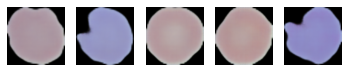

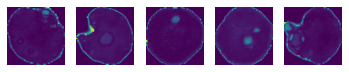

(1.8032149076461792, 169.63811561216812, 171.4413305198143)
[  3.94416269 207.17970108 211.12386377]


Epoch 32/200
9632/9632 [==============================] - 6s 583us/step - loss: 151.4042 - val_loss: 161.6783
Epoch 33/200
9632/9632 [==============================] - 6s 573us/step - loss: 149.1986 - val_loss: 159.0221
Epoch 34/200
9632/9632 [==============================] - 5s 570us/step - loss: 148.2628 - val_loss: 160.8470
Epoch 35/200
9632/9632 [==============================] - 6s 572us/step - loss: 146.7779 - val_loss: 161.1871
Epoch 36/200
9632/9632 [==============================] - 5s 567us/step - loss: 147.1551 - val_loss: 153.2465
normal


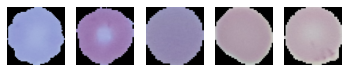

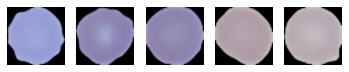

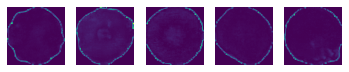

(2.0354833602905273, 118.91666030972934, 120.95214367001986)
[  3.19744673 140.57688914 143.77433587]


parasitic


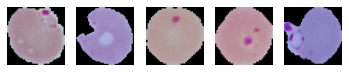

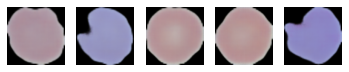

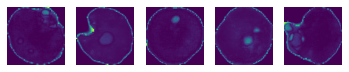

(1.955246925354004, 150.90596024448323, 152.86120716983723)
[  3.88738469 195.61592837 199.50331305]


Epoch 37/200
9632/9632 [==============================] - 5s 567us/step - loss: 144.8022 - val_loss: 159.5687
Epoch 38/200
9632/9632 [==============================] - 6s 579us/step - loss: 144.5915 - val_loss: 156.6679
Epoch 39/200
9632/9632 [==============================] - 6s 575us/step - loss: 142.0450 - val_loss: 152.5387
Epoch 40/200
9632/9632 [==============================] - 5s 569us/step - loss: 141.9250 - val_loss: 154.6326
Epoch 41/200
9632/9632 [==============================] - 5s 571us/step - loss: 141.1654 - val_loss: 150.0535
normal


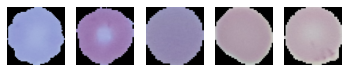

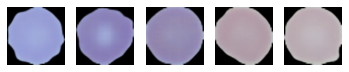

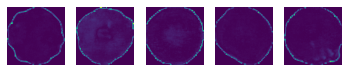

(1.8365989923477173, 118.17276236405752, 120.00936135640524)
[  3.11711472 137.339585   140.45669972]


parasitic


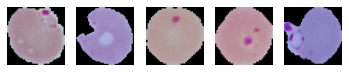

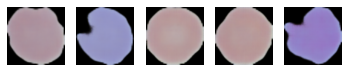

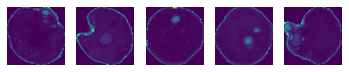

(1.8796095848083496, 140.99506052602405, 142.8746701108324)
[  3.83826624 192.22342257 196.06168881]


Epoch 42/200
9632/9632 [==============================] - 5s 570us/step - loss: 140.5750 - val_loss: 148.9591
Epoch 43/200
9632/9632 [==============================] - 6s 574us/step - loss: 138.7763 - val_loss: 150.1587
Epoch 44/200
9632/9632 [==============================] - 5s 569us/step - loss: 138.7667 - val_loss: 147.8397
Epoch 45/200
9632/9632 [==============================] - 6s 572us/step - loss: 137.3127 - val_loss: 158.1153
Epoch 46/200
9632/9632 [==============================] - 5s 570us/step - loss: 137.1193 - val_loss: 148.0526
normal


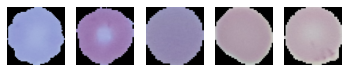

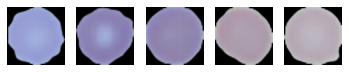

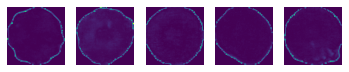

(1.93304443359375, 116.25959407833948, 118.19263851193323)
[  3.12994303 135.4607037  138.59064673]


parasitic


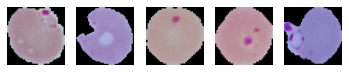

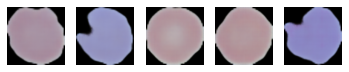

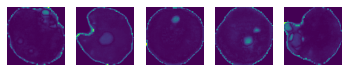

(1.898055911064148, 137.66472102793895, 139.5627769390031)
[  3.8317046  189.39788295 193.22958754]


Epoch 47/200
9632/9632 [==============================] - 6s 587us/step - loss: 136.1995 - val_loss: 149.4498
Epoch 48/200
9632/9632 [==============================] - 6s 577us/step - loss: 135.7311 - val_loss: 149.7843
Epoch 49/200
9632/9632 [==============================] - 6s 576us/step - loss: 135.2560 - val_loss: 148.8502
Epoch 50/200
9632/9632 [==============================] - 5s 561us/step - loss: 135.5710 - val_loss: 146.2457
Epoch 51/200
9632/9632 [==============================] - 6s 572us/step - loss: 133.6072 - val_loss: 146.2462
normal


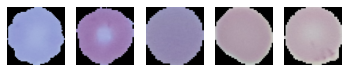

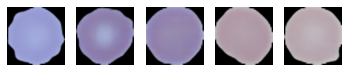

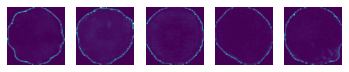

(1.7901253700256348, 121.47293256423919, 123.26305793426482)
[  2.95200494 135.0544408  138.00644574]


parasitic


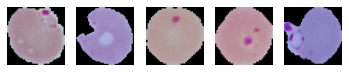

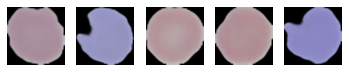

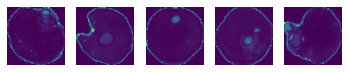

(1.819136619567871, 127.19833006089291, 129.01746668046079)
[  3.64717899 184.91593657 188.56311557]


Epoch 52/200
9632/9632 [==============================] - 5s 558us/step - loss: 134.2546 - val_loss: 150.2562
Epoch 53/200
9632/9632 [==============================] - 5s 570us/step - loss: 132.3119 - val_loss: 147.5373
Epoch 54/200
9632/9632 [==============================] - 5s 566us/step - loss: 133.6067 - val_loss: 146.5711
Epoch 55/200
9632/9632 [==============================] - 6s 581us/step - loss: 132.3578 - val_loss: 145.5453
Epoch 56/200
9632/9632 [==============================] - 6s 606us/step - loss: 131.6176 - val_loss: 146.0605
normal


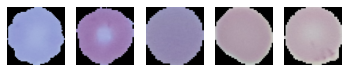

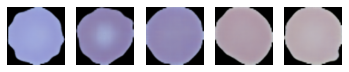

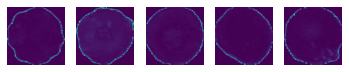

(1.8538758754730225, 113.78258124496352, 115.63645712043655)
[  2.94055778 135.43495527 138.37551304]


parasitic


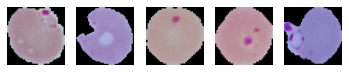

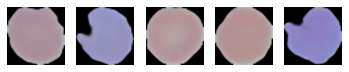

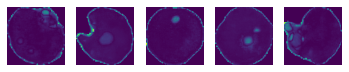

(1.913224220275879, 120.07645869309819, 121.98968291337407)
[  3.59517973 186.19609714 189.79127687]


Epoch 57/200
9632/9632 [==============================] - 6s 579us/step - loss: 132.3014 - val_loss: 147.2552
Epoch 58/200
9632/9632 [==============================] - 6s 574us/step - loss: 130.1505 - val_loss: 142.8869
Epoch 59/200
9632/9632 [==============================] - 6s 573us/step - loss: 130.2612 - val_loss: 148.9442
Epoch 60/200
9632/9632 [==============================] - 6s 598us/step - loss: 131.0020 - val_loss: 142.9115
Epoch 61/200
9632/9632 [==============================] - 6s 586us/step - loss: 129.1634 - val_loss: 142.7528
normal


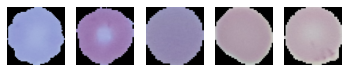

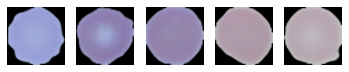

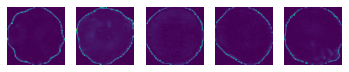

(1.6945809125900269, 114.9849648541429, 116.67954576673293)
[  2.81464561 131.37343985 134.18808547]


parasitic


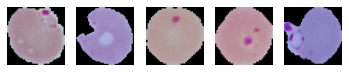

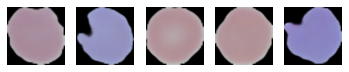

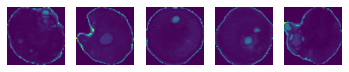

(1.8367741107940674, 119.41520554798085, 121.25197965877491)
[  3.45461556 184.19917796 187.65379352]


Epoch 62/200
9632/9632 [==============================] - 6s 590us/step - loss: 128.6124 - val_loss: 141.3764
Epoch 63/200
9632/9632 [==============================] - 5s 564us/step - loss: 128.6689 - val_loss: 143.0149
Epoch 64/200
9632/9632 [==============================] - 6s 574us/step - loss: 127.0904 - val_loss: 148.2233
Epoch 65/200
9632/9632 [==============================] - 6s 586us/step - loss: 127.3215 - val_loss: 144.4341
Epoch 66/200
9632/9632 [==============================] - 5s 569us/step - loss: 126.9112 - val_loss: 140.5730
normal


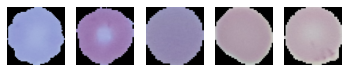

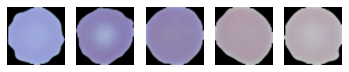

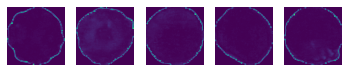

(1.6862612962722778, 111.10978983295881, 112.79605112923109)
[  2.79336098 130.58001516 133.37337614]


parasitic


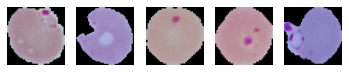

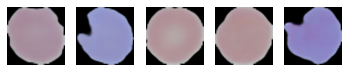

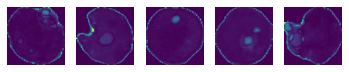

(1.853293776512146, 121.15540473342696, 123.00869850993911)
[  3.40374624 179.6347025  183.03844874]


Epoch 67/200
9632/9632 [==============================] - 6s 579us/step - loss: 126.1803 - val_loss: 140.2925
Epoch 68/200
9632/9632 [==============================] - 6s 571us/step - loss: 126.0336 - val_loss: 139.8042
Epoch 69/200
9632/9632 [==============================] - 5s 566us/step - loss: 125.1800 - val_loss: 142.6401
Epoch 70/200
9632/9632 [==============================] - 5s 558us/step - loss: 125.4010 - val_loss: 141.5486
Epoch 71/200
9632/9632 [==============================] - 6s 575us/step - loss: 125.4503 - val_loss: 140.4813
normal


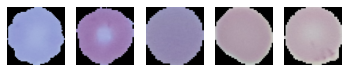

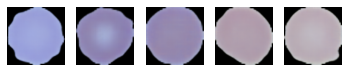

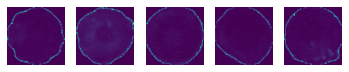

(1.7031254768371582, 107.95656434395801, 109.65968982079517)
[  2.82382368 129.46935943 132.29318311]


parasitic


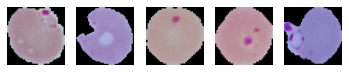

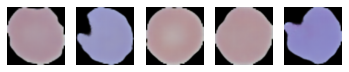

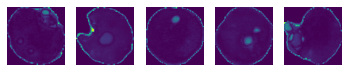

(1.9306139945983887, 117.9121055344294, 119.84271952902779)
[  3.42629988 180.95314032 184.3794402 ]


Epoch 72/200
9632/9632 [==============================] - 6s 571us/step - loss: 124.9424 - val_loss: 139.5176
Epoch 73/200
9632/9632 [==============================] - 6s 581us/step - loss: 126.0188 - val_loss: 140.4893
Epoch 74/200
9632/9632 [==============================] - 5s 555us/step - loss: 123.7613 - val_loss: 140.9284
Epoch 75/200
9632/9632 [==============================] - 5s 558us/step - loss: 123.6650 - val_loss: 141.8337
Epoch 76/200
9632/9632 [==============================] - 6s 571us/step - loss: 123.2185 - val_loss: 139.7131
normal


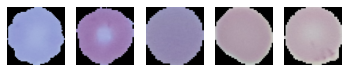

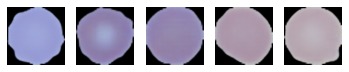

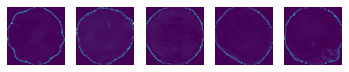

(1.4451661109924316, 107.16462913508406, 108.60979524607649)
[  2.60697499 128.88388339 131.49085838]


parasitic


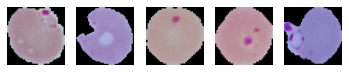

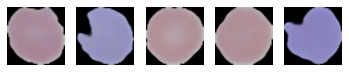

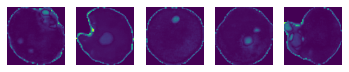

(1.7342381477355957, 112.3740771822136, 114.10831532994919)
[  3.19935816 181.15520452 184.35456267]


Epoch 77/200
9632/9632 [==============================] - 5s 558us/step - loss: 123.0953 - val_loss: 138.9860
Epoch 78/200
9632/9632 [==============================] - 5s 560us/step - loss: 122.7210 - val_loss: 138.8971
Epoch 79/200
9632/9632 [==============================] - 5s 568us/step - loss: 121.9211 - val_loss: 137.9221
Epoch 80/200
9632/9632 [==============================] - 5s 562us/step - loss: 121.7204 - val_loss: 137.7023
Epoch 81/200
9632/9632 [==============================] - 5s 561us/step - loss: 122.0581 - val_loss: 141.7404
normal


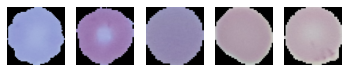

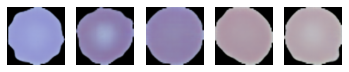

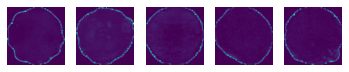

(1.4927880764007568, 115.52327382254597, 117.01606189894673)
[  2.54607158 130.78629971 133.33237129]


parasitic


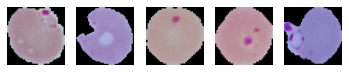

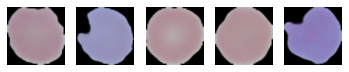

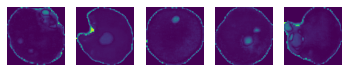

(1.6659902334213257, 120.52302117213195, 122.18901140555327)
[  3.10682108 181.28060594 184.38742702]


Epoch 82/200
9632/9632 [==============================] - 5s 562us/step - loss: 122.1351 - val_loss: 141.0132
Epoch 83/200
9632/9632 [==============================] - 5s 563us/step - loss: 121.8774 - val_loss: 138.9843
Epoch 84/200
9632/9632 [==============================] - 5s 565us/step - loss: 120.8387 - val_loss: 137.2773
Epoch 85/200
9632/9632 [==============================] - 5s 571us/step - loss: 120.0668 - val_loss: 137.1465
Epoch 86/200
9632/9632 [==============================] - 5s 565us/step - loss: 120.2444 - val_loss: 142.7993
normal


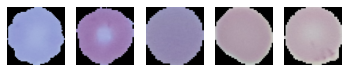

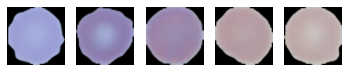

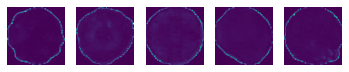

(1.6123762130737305, 115.48449516896181, 117.09687138203554)
[  2.68040657 133.38434695 136.06475352]


parasitic


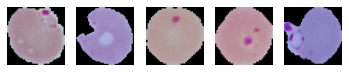

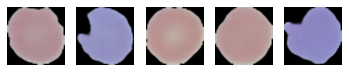

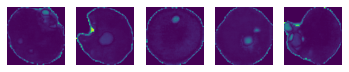

(1.7674002647399902, 124.74788149662017, 126.51528176136016)
[  3.27897651 180.75246543 184.03144193]


Epoch 87/200
9632/9632 [==============================] - 5s 561us/step - loss: 120.4949 - val_loss: 137.3808
Epoch 88/200
9632/9632 [==============================] - 5s 568us/step - loss: 119.4157 - val_loss: 137.0204
Epoch 89/200
9632/9632 [==============================] - 5s 562us/step - loss: 119.2818 - val_loss: 137.4477
Epoch 90/200
9632/9632 [==============================] - 6s 584us/step - loss: 118.9655 - val_loss: 138.4069
Epoch 91/200
9632/9632 [==============================] - 5s 568us/step - loss: 121.0088 - val_loss: 134.6800
normal


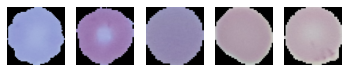

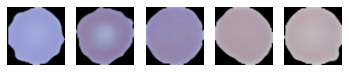

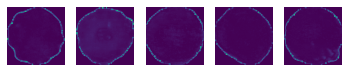

(1.4438581466674805, 108.94348120685206, 110.38733935351954)
[  2.5887213  124.34018407 126.92890538]


parasitic


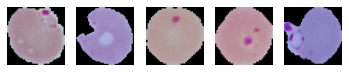

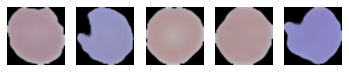

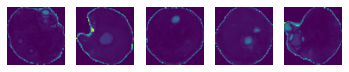

(1.7256308794021606, 116.07448099326061, 117.80011187266277)
[  3.1518794  177.23748981 180.38936921]


Epoch 92/200
9632/9632 [==============================] - 6s 572us/step - loss: 118.7655 - val_loss: 139.2702
Epoch 93/200
9632/9632 [==============================] - 6s 584us/step - loss: 117.8200 - val_loss: 135.4859
Epoch 94/200
9632/9632 [==============================] - 5s 561us/step - loss: 117.6642 - val_loss: 136.5240
Epoch 95/200
9632/9632 [==============================] - 5s 558us/step - loss: 117.6616 - val_loss: 136.6119
Epoch 96/200
2752/9632 [=======>......................] - ETA: 3s - loss: 116.3886

KeyboardInterrupt: ignored

In [ ]:
hist = vae.fit(x=imgs_train[:train_mult], y=imgs_train[:train_mult],
               shuffle=True,
               epochs=200,
               batch_size=batch_size,
               validation_data=(imgs_val[:val_mult], imgs_val[:val_mult]),
               callbacks=[Display(), checkpoint])

In [14]:
p_ae = np.clip(vae.predict(p_imgs[:32]), 0.0, 1.0)
p_mu, p_logvar = enc.predict(p_imgs)

NameError: ignored

In [ ]:
p_kl = [list(vlb_num(p_imgs[i], p_ae[i], p_mu[i], p_logvar[i])) for i in range(96)]
p_kl = np.array(p_kl)

In [ ]:
np_ae = np.clip(vae.predict(imgs_val[:256]), 0.0, 1.0)
np_mu, np_logvar = enc.predict(imgs_val[:256])

In [ ]:
np_kl = [list(vlb_num(imgs_val[i], np_ae[i], np_mu[i], np_logvar[i])) for i in range(96)]
np_kl = np.array(np_kl)
np_kl.shape

(96, 3)

In [ ]:
cv2.imwrite('np1.png', imgs_val[0]*255.0)

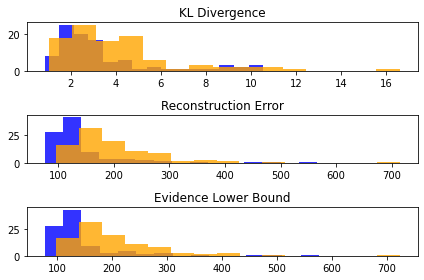

In [ ]:
fig, axs = plt.subplots(3, 1, tight_layout=True)
for i in range(3):
  axs[i].hist(np_kl[:,i], color='blue', alpha=0.8, bins=15)
  axs[i].hist(p_kl[:,i], color='orange', alpha=0.8, bins=15)
axs[0].title.set_text('KL Divergence')
axs[1].title.set_text('Reconstruction Error')
axs[2].title.set_text('Evidence Lower Bound')
fig.show()

In [ ]:
from sklearn.manifold import TSNE
reduced = TSNE(n_components=2).fit_transform(np_mu)

In [ ]:
reduced.shape

In [ ]:
plt.scatter(reduced[:,0], reduced[:,1])

In [ ]:
!ls '/gdrive/My Drive/malaria-dataset/models/'

base	    dense_lt64_1  dense_lt64_klw1.0	 dense_lt64_klw1.0_mse_2
dense_lt64  dense_lt64_2  dense_lt64_klw1.0_mse  mseACTUAL


In [ ]:
!ls '/gdrive/My Drive/malaria-dataset/models/mseACTUAL'

01-426.78.h5  20-177.94.h5  39-152.54.h5  58-142.89.h5	77-138.99.h5
02-349.87.h5  21-173.30.h5  40-154.63.h5  59-148.94.h5	78-138.90.h5
03-317.94.h5  22-173.55.h5  41-150.05.h5  60-142.91.h5	79-137.92.h5
04-297.51.h5  23-174.49.h5  42-148.96.h5  61-142.75.h5	80-137.70.h5
05-250.96.h5  24-172.28.h5  43-150.16.h5  62-141.38.h5	81-141.74.h5
06-233.58.h5  25-167.80.h5  44-147.84.h5  63-143.01.h5	82-141.01.h5
07-220.25.h5  26-168.38.h5  45-158.12.h5  64-148.22.h5	83-138.98.h5
08-213.22.h5  27-168.13.h5  46-148.05.h5  65-144.43.h5	84-137.28.h5
09-205.62.h5  28-161.83.h5  47-149.45.h5  66-140.57.h5	85-137.15.h5
10-203.22.h5  29-167.42.h5  48-149.78.h5  67-140.29.h5	86-142.80.h5
11-198.71.h5  30-160.62.h5  49-148.85.h5  68-139.80.h5	87-137.38.h5
12-192.72.h5  31-163.73.h5  50-146.25.h5  69-142.64.h5	88-137.02.h5
13-192.79.h5  32-161.68.h5  51-146.25.h5  70-141.55.h5	89-137.45.h5
14-194.32.h5  33-159.02.h5  52-150.26.h5  71-140.48.h5	90-138.41.h5
15-185.83.h5  34-160.85.h5  53-147.54.h5  72-139

In [16]:
vae.load_weights('/gdrive/My Drive/malaria-dataset/models/mseACTUAL/91-134.68.h5')

In [15]:
img_input = Input(batch_shape=(1, 96, 96, 3))

enc = make_encoder((96, 96, 3))
t_mean, t_log_var = enc(img_input)

dec = make_decoder()
decoder_mean = dec(t_mean)

vae = Model(inputs=img_input, outputs=[decoder_mean, t_mean, t_log_var])

In [17]:
vae.compile('Adam', 'mse')

In [18]:
vae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, 96, 96, 3)            0         
_________________________________________________________________
model_1 (Model)              multiple                  385984    
_________________________________________________________________
model_2 (Model)              multiple                  230787    
Total params: 616,771
Trainable params: 616,771
Non-trainable params: 0
_________________________________________________________________


In [19]:
vae.save('model.h5')

In [20]:
model_tf = tf.keras.models.load_model('model.h5')

In [21]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model_tf)

tflite_model = converter.convert()

tflite_model_path = 'model_mseACTUALe91_det_multout.tflite'

print(tflite_model_path)

with tf.io.gfile.GFile(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

model_mseACTUALe91_det_multout.tflite


In [22]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path='model_mseACTUALe91_det_multout.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [23]:
def vlb_num(img, img_ae, mu, logvar, kl_weight=1):
	kl = 0.5 * np.sum((np.exp(logvar) + np.square(mu) - 1.0 - logvar), axis=-1)
	mse = np.square(img - img_ae)
	mse = np.sum(mse, axis=(0, 1, 2))
	return kl, mse, kl_weight * kl + mse

In [24]:
imgs_val.shape

(1378, 96, 96, 3)

In [25]:
def get_vlbs(imgs_in, num=96):
  vlbs = []
  for i in range(num):
    interpreter.set_tensor(input_details[0]['index'], np.float32(np.expand_dims(imgs_in[i], axis=0), axis=0))

    interpreter.invoke()

    mean = interpreter.get_tensor(output_details[0]['index'])
    logvar = interpreter.get_tensor(output_details[1]['index'])
    ae = interpreter.get_tensor(output_details[2]['index'])

    vlb_res = vlb_num(imgs_val[i], ae[0], mean[0], logvar[0])

    vlbs.append(list(vlb_res))
  return np.array(vlbs)

In [32]:
np_vlbs = get_vlbs(imgs_val, num=256)
p_vlbs = get_vlbs(p_imgs, num=96)
print(np_vlbs.shape)
print(p_vlbs.shape)

(256, 3)
(96, 3)


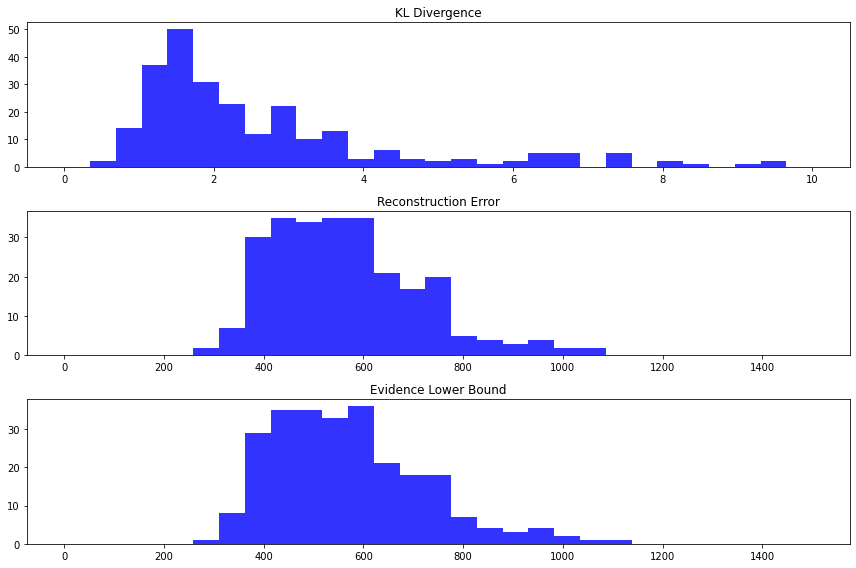

In [33]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(12, 8))

axs[0].hist(np_vlbs[:,0], color='blue', alpha=0.8, bins=np.linspace(0, 10, 30))
#axs[0].hist(p_vlbs[:,0], color='orange', alpha=0.8, bins=np.linspace(0, 10, 30))

axs[1].hist(np_vlbs[:,1], color='blue', alpha=0.8, bins=np.linspace(0, 1500, 30))
#axs[1].hist(p_vlbs[:,1], color='orange', alpha=0.8, bins=np.linspace(0, 1500, 30))

axs[2].hist(np_vlbs[:,2], color='blue', alpha=0.8, bins=np.linspace(0, 1500, 30))
#axs[2].hist(p_vlbs[:,2], color='orange', alpha=0.8, bins=np.linspace(0, 1500, 30))

axs[0].title.set_text('KL Divergence')
axs[1].title.set_text('Reconstruction Error')
axs[2].title.set_text('Evidence Lower Bound')
fig.show()